In [1]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhavyabhola","key":"eb3e9700af77a8f741cacbf4ecd9061b"}'}

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

 84% 25.0M/29.6M [00:01<00:00, 18.7MB/s]
100% 29.6M/29.6M [00:01<00:00, 25.5MB/s]


In [8]:
!unzip semantic-segmentation-of-aerial-imagery

Archive:  semantic-segmentation-of-aerial-imagery.zip
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_001.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_002.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_003.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_004.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_005.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_006.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_007.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_008.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_009.jpg  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_001.png  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_002.png  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_003.png  
  inflating: 

In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify
import os
from sklearn.preprocessing import MinMaxScaler , StandardScaler

scalar = StandardScaler()
n_classes = 6
root_dir = "/content/Semantic segmentation dataset"
patch_size = 256

image_dataset = []
for path , subdir , files in os.walk(root_dir): 
  dirname = path.split(os.path.sep)[-1]
  if dirname == 'images':
    images = os.listdir(path)
    images.sort()
    for i , image_name in enumerate(images):
      if image_name.endswith(".jpg"):
        
        image = cv.imread(path+'/'+image_name,1)
        size_x = (image.shape[0]//patch_size)*patch_size
        size_y = (image.shape[1]//patch_size)*patch_size
        image = Image.fromarray(image)
        image = image.crop((0,0,size_x,size_y))
        image = np.array(image)
        #patching the large image into small 256x256 images

        patches = patchify(image , (patch_size , patch_size,3) , step=patch_size) 

        for i in range(patches.shape[0]):
          for j in range(patches.shape[1]):

            single_patch = patches[i ,j ,0,:,:]
            single_patch = scalar.fit_transform(single_patch.reshape(-1, single_patch.shape[-1])).reshape(single_patch.shape)
            
            image_dataset.append(single_patch)   

In [10]:
mask_dataset=[]
for path , subdir , files in os.walk(root_dir): 
  dirname = path.split(os.path.sep)[-1]
  if dirname == 'masks':
    masks = os.listdir(path)
    masks.sort()
    for i , mask_name in enumerate(masks):
      if mask_name.endswith(".png"):
        
        mask = cv.imread(path+'/'+mask_name,1)
        mask = cv.cvtColor(mask , cv.COLOR_BGR2RGB)
        size_x = (mask.shape[0]//patch_size)*patch_size
        size_y = (mask.shape[1]//patch_size)*patch_size
        mask = Image.fromarray(mask)
        mask = mask.crop((0,0,size_x,size_y))
        mask = np.array(mask)
        #patching the large image into small 256x256 images

        patches = patchify(mask , (patch_size , patch_size,3) , step = patch_size) 

        for i in range(patches.shape[0]):
          for j in range(patches.shape[1]):

            single_patch = patches[i ,j ,0,:,:]
            
            mask_dataset.append(single_patch)            


In [11]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [12]:
# converting hex to rgb 
building = '#3C1098'.lstrip('#')
building = np.array(tuple(int(building[i:i+2],16) for i in (0,2,4)))

land = '#8429F6'.lstrip('#')
land = np.array(tuple(int(land[i:i+2],16) for i in (0,2,4)))

road = '#6EC1E4'.lstrip('#')
road = np.array(tuple(int(road[i:i+2],16)  for i in (0,2,4)))

vegetation = '#FEDD3A'.lstrip('#')
vegetation = np.array(tuple(int(vegetation[i:i+2],16)  for i in (0,2,4)))

water = '#E2A929'.lstrip('#')
water = np.array(tuple(int(water[i:i+2],16)  for i in (0,2,4)))

unlabeled = '#9B9B9B'.lstrip('#')
unlabeled = np.array(tuple(int(unlabeled[i:i+2],16)  for i in (0,2,4)))

In [13]:
def rgb_to_2d_label(label):
  label_seg = np.zeros(label.shape , dtype=np.uint8)
  label_seg[np.all(label==building , axis=-1)] = 0
  label_seg[np.all(label==land , axis=-1)] = 1
  label_seg[np.all(label==road , axis=-1)] = 2
  label_seg[np.all(label==vegetation , axis=-1)] = 3
  label_seg[np.all(label==water , axis=-1)] = 4
  label_seg[np.all(label==unlabeled , axis=-1)] = 5

  label_seg = label_seg[:,:,0]
  
  return label_seg

In [14]:
labels = []

for i in range(mask_dataset.shape[0]):
  label = rgb_to_2d_label(mask_dataset[i])
  labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels , axis=3)

In [15]:
from keras.utils import to_categorical

labels_cat = to_categorical(labels , num_classes = n_classes)

In [16]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(image_dataset , labels_cat , test_size = 0.2, random_state = 42)

In [17]:
del image_dataset, mask_dataset, labels_cat, labels

In [18]:
from tensorflow.keras import backend as K 

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)



def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [20]:
from tensorflow.keras.models import load_model

model = load_model("/content/ais.h5" , custom_objects={'dice_coef_loss':dice_coef_loss})

In [96]:
import random
y_test_argmax=np.argmax(y_test, axis=3)
test_img_number = random.randint(0, len(x_test))
test_img = x_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]



1/1 [==============================] - 0s 159ms/step


In [97]:
print(predicted_img)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [4 1 4 ... 0 0 1]
 [3 4 4 ... 0 1 1]
 [3 1 1 ... 0 1 1]]


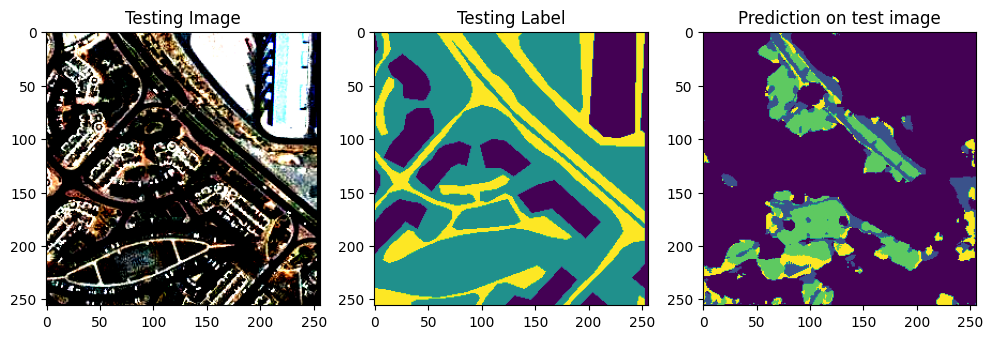

In [98]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()